In [10]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import STL
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


In [2]:
gwic_filename = 'data/missoula_valley_monitored_wells_data.csv'
usgs_filename = 'data/clark_fk_above_missoula_q.csv'
gw_df = pd.read_csv(gwic_filename, index_col='time', parse_dates=True)
q_df = pd.read_csv(usgs_filename, index_col='time', parse_dates=True)

In [3]:
df = pd.concat([q_df, gw_df], axis=1, join='inner')

## Data Imputation

### Seasonal Trend Decomposition using Loess (STL)
See [Medium blog post](https://medium.com/@aaabulkhair/data-imputation-demystified-time-series-data-69bc9c798cb7)

In [4]:
# Copy dataframe to create new dataframe for imputed data
stl_imputed = df.copy()

In [5]:
for c in np.arange(1, df.shape[1]):
    
    # Drop preceding NaNs
    first_ind = df.iloc[:, c].first_valid_index()
    new_df = df.iloc[:, c][first_ind:]  
    
    # Get indices of NaNs
    imputed_indices = new_df[new_df.isnull()].index

    # Pull out 5 random points for test data
    values_indices = new_df.index.difference(imputed_indices)
    test_indices = np.random.choice(values_indices, 5, replace=False)
    test_values = new_df[test_indices]
    new_df.loc[test_indices] = np.nan

    # Need to interpolate and drop first row because STL doesn't handle NaNs
    new_df = new_df.ffill()
    # new_df = new_df.drop(new_df.index[0])

    # Apply STL decomposition to the groundwater level data
    stl = STL(new_df, seasonal=7, period=12, robust=True)
    res = stl.fit()

    # Extract the seasonal component
    seasonal = res.seasonal
    
    # Created deseasonalized groundwater level data
    df_deseas = new_df - seasonal

    # Interpolate the deseasonalized data
    df_deseas_int = df_deseas.interpolate(method='linear')

    # Add seasonal component back to deseasonalized data
    df_imputed = df_deseas_int + seasonal
    
    # Replace NaNs with imputed data
    stl_imputed.iloc[:, c][imputed_indices] = df_imputed[imputed_indices]
    
    # Aggregate test data
    test_data = pd.concat([test_values, df_imputed[test_indices]], axis=1)
    test_data.columns = ['value', 'estimate']
    if c == 1:
        stl_test_data = test_data
    else:
        stl_test_data = pd.concat([stl_test_data, test_data], axis=0)

In [13]:
# Calculate error statistics
stl_mae = mean_absolute_error(stl_test_data['value'], stl_test_data['estimate'])
stl_mse = mean_squared_error(stl_test_data['value'], stl_test_data['estimate'])
stl_rmse = np.sqrt(stl_mse)
stl_mape = np.mean(np.abs((stl_test_data['value'] - stl_test_data['estimate']) / stl_test_data['value'])) * 100
stl_rsquared = r2_score(stl_test_data['value'], stl_test_data['estimate'])
stl_rsquared

0.9724809517705917

<Axes: xlabel='time'>

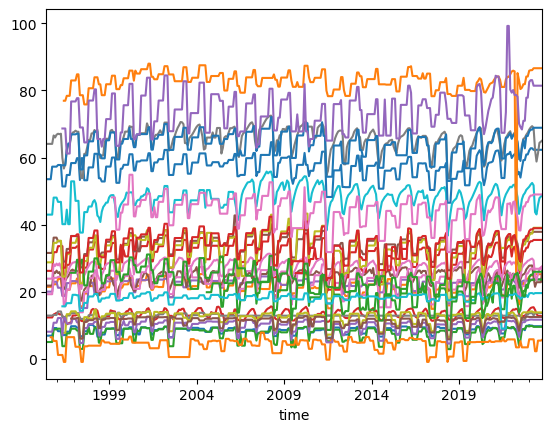

In [14]:
# Plot
stl_imputed.iloc[:, 1:].plot(legend=False)

## Regression imputation using Clark Fk flows